![](./img/upld_57150.jpeg)

# Дата-сайенc проект для компании Booking

In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
# для нормализации, стандартизации
from sklearn import preprocessing

# импортируем хи-квадрат
from sklearn.feature_selection import chi2 

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

import geopy.geocoders
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# прописываем функции
def rev_func(num_tags):
    """Функция которая делит строку по разделителю

    Args:
        num_tags (object): строка, которую необходимо преобразовать в список

    Returns:
        list: список пригодный для дальнейшей обработки
    """
    # обрезаем ненужные символы по краям
    num_tags = num_tags[2:-2]
    # преобразуем в список который легче обработать
    res = num_tags.strip().split(' \', \' ')
    return res


def get_season(month):
    """Функция для определения времени года по номеру месяца

    Args:
        month (int): номер месяца в году от 1 до 12

    Returns:
        str: Название времени года: 4 варианта: winter, spring, summer, outumn
    """
    if month in [12,1,2]:
        season = 'winter'
    elif month in [3,4,5]:
        season = 'spring'
    elif month in [6,7,8]:
        season = 'summer'
    else:
        season = 'outumn'
    return season


def get_positive_cat(review):
    """Функция вычленения ключевых слов из текста

    Args:
        review (str): текст из которого вычленяем шаблон

    Returns:
        str: одна из категорий:'Nothing', 'Location', 'Staff', 'Breakfast', 'Everithing', 'Other'
    """
    if ('no positive' or 'nothing') in review.lower():
        return 'Nothing'
    elif ('location' or 'position') in review.lower():
        return 'Location'
    elif 'staff' in review.lower():
        return 'Staff'
    elif 'breakfast' in review.lower():
        return 'Breakfast'
    elif 'everything' in review.lower():
        return 'Everithing'    
    else:
        return 'Other'
    
    
def get_negative_cat(review):
    """Функция вычленения ключевых слов из текста

    Args:
        review (str): текст из которого вычленяем шаблон

    Returns:
        str: одна из категорий:'Nothing', 'Location', 'Staff', 'Breakfast', 'Everithing', 'Other'
    """
    
    if ('no negative'or 'nothing'or 'none'or 'n a'or 'na'or 'everything was') in review.lower():
        return 'Nothing'
    elif ('location' or 'position') in review.lower():
        return 'Location'
    elif 'staff' in review.lower():
        return 'Staff'
    elif 'breakfast' in review.lower():
        return 'Breakfast'
    elif 'room' in review.lower():
        return 'Room'    
    else:
        return 'Other'    

In [3]:
# загружаем данные
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [4]:
# знакомство с типами данных
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Вывод: нам есть что преобразовать

# Преобразование данных

In [5]:
# копируем исходный датасет для обработки данных
hotels_copy = hotels.copy()

In [6]:
# приводим признак  review_date к формату datetime
hotels_copy['review_date'] = pd.to_datetime(hotels_copy['review_date'], dayfirst=False)

In [7]:
# определяем период времени в который оставлены отзывы
hotels_copy['review_date'].sort_values(ascending=True)

143997   2015-08-04
86268    2015-08-04
159209   2015-08-04
217001   2015-08-04
28485    2015-08-04
            ...    
167325   2017-08-03
372341   2017-08-03
54669    2017-08-03
321881   2017-08-03
315137   2017-08-03
Name: review_date, Length: 386803, dtype: datetime64[ns]

1. Выделим из признака `review_date` категориальные признаки: `is_weekend_review` (1 - выходные, сб. вс., 0 - будни, пн.-пт.), `review_month` - месяц (1-12),  `review_season` - время года отзыва (1 - зима, 2 - весна, 3 - лето, 4 - осень)

In [8]:
hotels_copy['is_weekend_review'] = hotels_copy['review_date'].dt.dayofweek.apply(lambda x: 'weekend' if x in [5,6] else 'weekdays')
hotels_copy['is_weekend_review'].value_counts(normalize=True)*100

is_weekend_review
weekdays    73.640587
weekend     26.359413
Name: proportion, dtype: float64

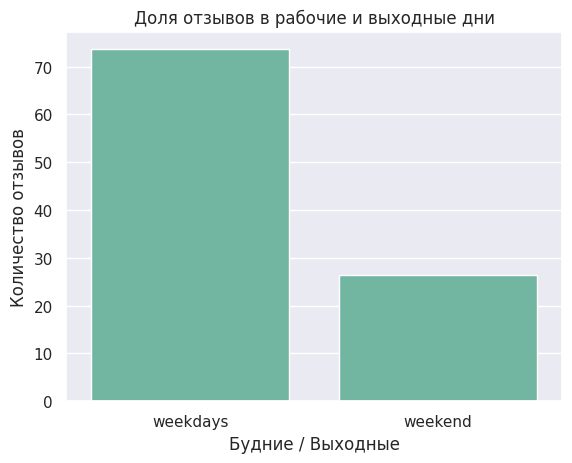

In [9]:
# визуализируем
ax = sns.countplot(hotels_copy, x="is_weekend_review", stat='percent')
ax.set(xlabel='Будние / Выходные', ylabel='Количество отзывов')
plt.title('Доля отзывов в рабочие и выходные дни')
plt.show()

In [9]:
hotels_copy['review_weekday'] = hotels_copy['review_date'].dt.weekday
hotels_copy['review_weekday'].value_counts(normalize=True)*100

review_weekday
1    23.514295
6    16.296668
0    15.699465
3    14.441718
2    11.338071
5    10.062745
4     8.647037
Name: proportion, dtype: float64

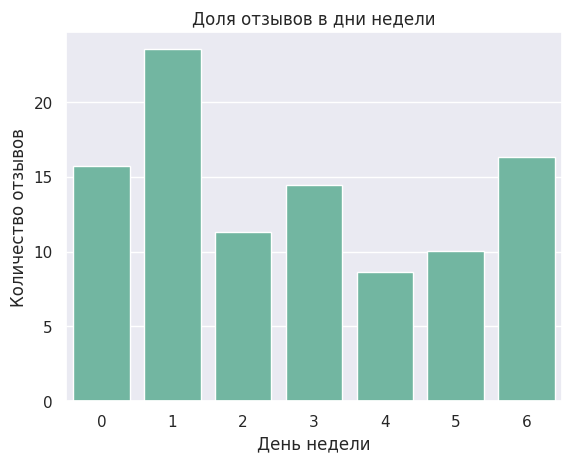

In [11]:
# визуализируем
ax = sns.countplot(hotels_copy, x="review_weekday", stat='percent')
ax.set(xlabel='День недели', ylabel='Количество отзывов')
plt.title('Доля отзывов в дни недели')
plt.show()

In [10]:
hotels_copy['review_month'] = hotels_copy['review_date'].dt.month
(hotels_copy['review_month'].value_counts(normalize=True)*100).sort_index()

review_month
1     8.146783
2     7.428846
3     7.988821
4     8.328012
5     8.966838
6     8.331373
7     9.602045
8     9.801113
9     8.220722
10    8.524236
11    6.979522
12    7.681688
Name: proportion, dtype: float64

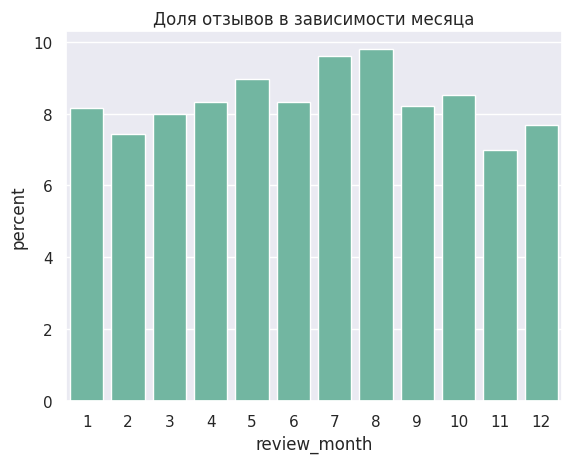

In [13]:
# визуализируем
x = sns.countplot(hotels_copy, x="review_month", stat='percent')
ax.set(xlabel='Месяц', ylabel='Количество отзывов')
plt.title('Доля отзывов в зависимости месяца')
plt.show()

In [11]:
hotels_copy['review_season'] = hotels_copy['review_month'].apply(get_season)
(hotels_copy['review_season'].value_counts(normalize=True)*100)

review_season
summer    27.734532
spring    25.283672
outumn    23.724480
winter    23.257317
Name: proportion, dtype: float64

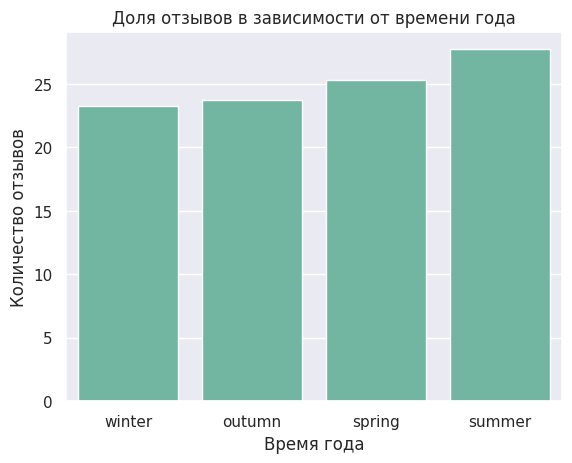

In [15]:
# визуализируем
ax = sns.countplot(hotels_copy, x="review_season", stat='percent')
ax.set(xlabel='Время года', ylabel='Количество отзывов')
plt.title('Доля отзывов в зависимости от времени года')
plt.show()

**Выводы:** признак `is_weekend_review` делит данные неравномерно, но пропорционально среднедневному количеству отзывов, выглядит перспективно. Остальные признаки распределены +/- равномерно.

In [12]:
hotels_copy['hotel_address'].value_counts()

hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
                                                                                  ... 
Via Palmanova 153 20132 Milan Italy                                                  7
40 Rue Rene Boulanger 10th arr 75010 Paris France                                    7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                              6
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              6
13 Rue Fran ois Ory 92120 Paris France                                               5
Name: count, Length: 1493, dt

2. Выделим из признака `hotel_adress` страну расположения отеля и создадим признак `hotel_country`;

In [12]:
hotels_copy['hotel_country'] = hotels_copy['hotel_address'].apply(
    # с помощью лямбда функции
    # оставляем последние два слова
    lambda x:' '.join(x.strip().split(' ')[-2:]) 
    # если предпоследнее слово 'United'
    if x.strip().split(' ')[-2] == 'United' 
    # в остальных случаях оставляем 1 слово
    else x.strip().split(' ')[-1])

# проверяем количество уникальных значений
hotels_copy['hotel_country'].value_counts()

hotel_country
United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: count, dtype: int64

In [14]:
tryn = hotels_copy['hotel_address'].apply(
    # с помощью лямбда функции
    # оставляем пятое с конца слово
    lambda x: x.strip().split(' ')[-5] 
    # если предпоследнее слово 'United'
    if x.strip().split(' ')[-2] == 'United' 
    # в остальных случаях оставляем 1 слово
    else x.strip().split(' ')[-2])

# проверяем количество уникальных значений
tryn.value_counts()

hotel_address
London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: count, dtype: int64

In [16]:
list(tryn.value_counts().index)

['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan']

In [18]:
API_KEY = 'c7nmNcApSLMeO/AQmEPEOg==q1m6ZeaIqO8Lpr7c'
# URL = 

In [27]:
import requests
name = 'London'
api_url = 'https://api.api-ninjas.com/v1/airports?name={}'.format(name)
response = requests.get(api_url, headers={'X-Api-Key': API_KEY})
if response.status_code == requests.codes.ok:
    print(response.text)
else:
    print("Error:", response.status_code, response.text)


[{"icao": "CLC2", "iata": "", "name": "London / Chapeskie Field", "city": "London", "region": "Ontario", "country": "CA", "elevation_ft": "930", "latitude": "43.0682983398", "longitude": "-81.1256027222", "timezone": "America/Toronto"}, {"icao": "CYXU", "iata": "YXU", "name": "London Airport", "city": "London", "region": "Ontario", "country": "CA", "elevation_ft": "912", "latitude": "43.0355987549", "longitude": "-81.1539001465", "timezone": "America/Toronto"}, {"icao": "EGGW", "iata": "LTN", "name": "London Luton Airport", "city": "London", "region": "England", "country": "GB", "elevation_ft": "526", "latitude": "51.8746986389", "longitude": "-0.3683330119", "timezone": "Europe/London"}, {"icao": "EGKB", "iata": "BQH", "name": "London Biggin Hill Airport", "city": "London", "region": "England", "country": "GB", "elevation_ft": "598", "latitude": "51.3307991028", "longitude": "0.0324999988", "timezone": "Europe/London"}, {"icao": "EGKK", "iata": "LGW", "name": "London Gatwick Airport",

In [30]:
response.text

'[{"icao": "CLC2", "iata": "", "name": "London / Chapeskie Field", "city": "London", "region": "Ontario", "country": "CA", "elevation_ft": "930", "latitude": "43.0682983398", "longitude": "-81.1256027222", "timezone": "America/Toronto"}, {"icao": "CYXU", "iata": "YXU", "name": "London Airport", "city": "London", "region": "Ontario", "country": "CA", "elevation_ft": "912", "latitude": "43.0355987549", "longitude": "-81.1539001465", "timezone": "America/Toronto"}, {"icao": "EGGW", "iata": "LTN", "name": "London Luton Airport", "city": "London", "region": "England", "country": "GB", "elevation_ft": "526", "latitude": "51.8746986389", "longitude": "-0.3683330119", "timezone": "Europe/London"}, {"icao": "EGKB", "iata": "BQH", "name": "London Biggin Hill Airport", "city": "London", "region": "England", "country": "GB", "elevation_ft": "598", "latitude": "51.3307991028", "longitude": "0.0324999988", "timezone": "Europe/London"}, {"icao": "EGKK", "iata": "LGW", "name": "London Gatwick Airport"

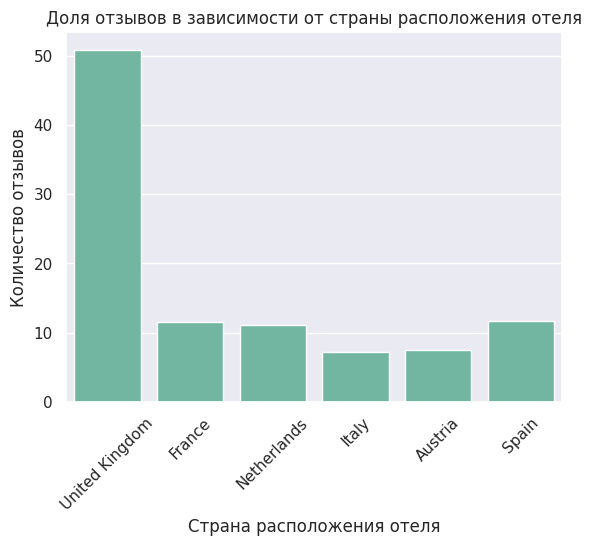

In [17]:
# визуализируем
ax = sns.countplot(hotels_copy, x="hotel_country", stat='percent')
ax.set(xlabel='Страна расположения отеля', ylabel='Количество отзывов')
plt.title('Доля отзывов в зависимости от страны расположения отеля')
plt.xticks(rotation=45)
plt.show()

**Выводы:** признак `hotel_country` делит данные неравномерно, около половины отзывов оставлены на отели расположенные в Великобритании.

3. Создадим признак `review_equal` при совпадении страны расположения (`hotel_country`) отеля со страной отзыва (`review_nationality`) - 1, при несовпадении - 0;

In [13]:
hotels_copy['review_equal'] = hotels_copy.apply(lambda row: 1 
                                                # сравниваем значения в столбцах 'hotel_country' 'reviewer_nationality'
                                                if row.hotel_country in row.reviewer_nationality
                                                else 0, axis=1)
hotels_copy['review_equal'].value_counts()

review_equal
0    252862
1    133941
Name: count, dtype: int64

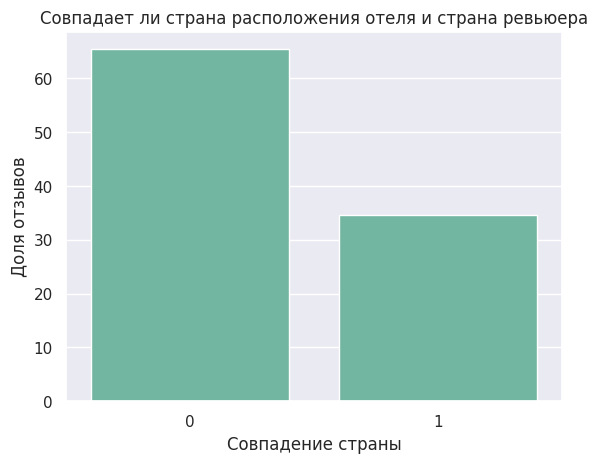

In [19]:
# визуализируем
ax = sns.countplot(hotels_copy, x="review_equal", stat='percent')
ax.set(xlabel='Совпадение страны', ylabel='Доля отзывов')
plt.title('Совпадает ли страна расположения отеля и страна ревьюера')

plt.show()

**Выводы:** признак `review_equal` делит данные неравномерно, чуть более 30 % отзыввов оставлены людьми из тоже страны в которой расположен отель.

4. Преобразуем признаки `positive_review`, `negative_review` к категориальным признакам;

In [14]:
hotels_copy['positive_review_cat'] = hotels_copy['positive_review'].apply(get_positive_cat)
hotels_copy['positive_review_cat'].value_counts()

positive_review_cat
Location      142044
Other         102678
Staff          83780
Nothing        26887
Breakfast      22406
Everithing      9008
Name: count, dtype: int64

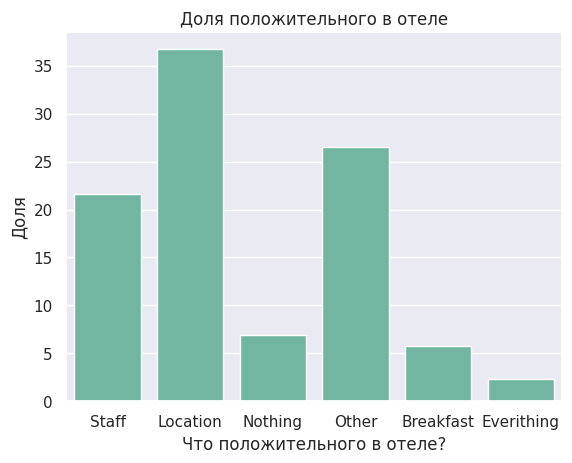

In [21]:
# визуализируем
ax = sns.countplot(hotels_copy, x="positive_review_cat", stat='percent')
ax.set(xlabel='Что положительного в отеле?', ylabel='Доля')
plt.title('Доля положительного в отеле')
# plt.xticks(rotation=45)
plt.show()

**Выводы:** признак `positive_review_cat` делит данные неравномерно, чуть более 35% отзыввов отмечают расположение в качестве положительной сторону расположение отеля, и чуть более 5% указали отсутствие положительных сторон.

In [15]:
hotels_copy['negative_review_cat'] = hotels_copy['negative_review'].apply(get_negative_cat)
hotels_copy['negative_review_cat'].value_counts()

negative_review_cat
Other        132804
Nothing       96173
Room          93192
Breakfast     31417
Staff         25063
Location       8154
Name: count, dtype: int64

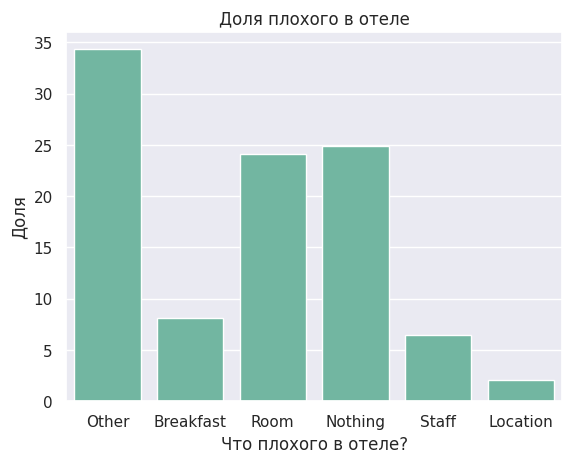

In [23]:
# визуализируем
ax = sns.countplot(hotels_copy, x="negative_review_cat", stat='percent')
ax.set(xlabel='Что плохого в отеле?', ylabel='Доля')
plt.title('Доля плохого в отеле')
plt.show()

**Выводы:** признак `negative_review_cat` делит данные неравномерно, чуть более 30% отзывов отмечают другие негативные стороны, 25% указали на отсутствие негативных сторон, 25% - на комнаты, около 7% на завтрак

5. Преобразуем признак `days_since_review` в числовой

In [16]:
hotels_copy['days_since_review'] = hotels_copy['days_since_review'].apply(lambda x: x.split(' ')[0])
hotels_copy['days_since_review'] = hotels_copy['days_since_review'].astype('int64')

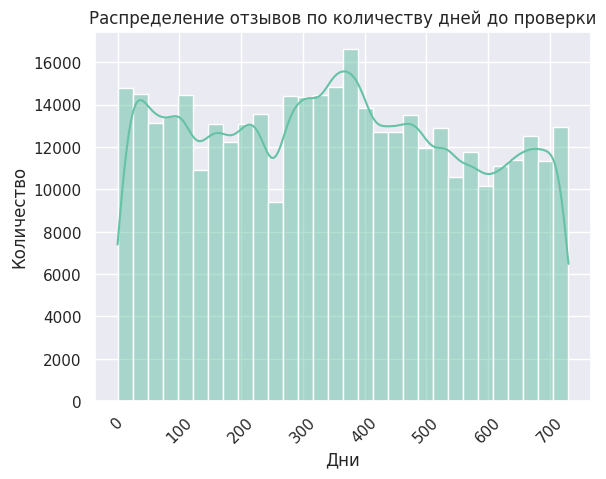

In [25]:
# визуализируем
ax = sns.histplot(data=hotels_copy, x='days_since_review', bins=30, discrete=False, kde=True)
ax.set(xlabel='Дни', ylabel='Количество')
plt.title('Распределение отзывов по количеству дней до проверки')
plt.xticks(rotation=45)
plt.show()

**Выводы:** значения признака `days_since_review` распределены равномерно, распределение отличное от нормального. 

6. Посчитаем количество тэгов в отзыве и создадим признак `tags_n`

In [17]:
def rev_func_len(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return len(res)

In [18]:
hotels_copy['tags_n'] = hotels_copy['tags'].apply(rev_func_len)
hotels_copy['tags_n'].value_counts()

tags_n
5    223455
4    158589
3      4126
6       563
2        65
1         5
Name: count, dtype: int64

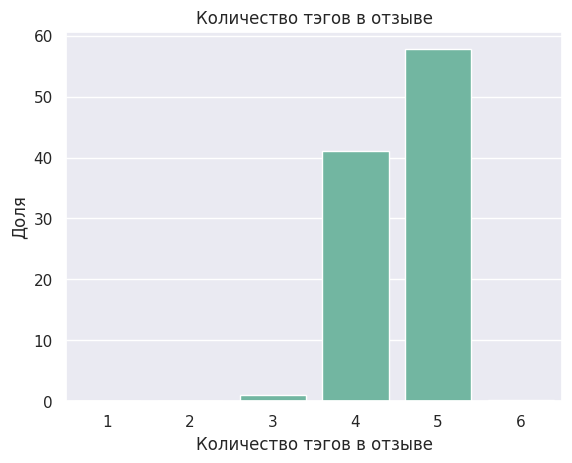

In [28]:
ax = sns.countplot(hotels_copy, x="tags_n", stat='percent')
ax.set(xlabel='Количество тэгов в отзыве', ylabel='Доля')
plt.title('Количество тэгов в отзыве')
plt.show()

**Вывод:** получился порядковый категориальный признак в более 90 % отзывов 4 или 5 тэгов 

In [19]:
# Отвечаем на контрольный вопрос с платформы: Количество уникальных тэгов?

n_hotels = hotels_copy.copy()

def rev_func_len(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return len(res)

n_hotels['tags_n'] = n_hotels['tags'].apply(rev_func)


n_hotels = n_hotels.explode('tags_n')
len(n_hotels['tags_n'].unique())

2368

In [20]:
# Выводим список популярных тэгов

n_hotels['tags_n'].value_counts().nlargest(50)

tags_n
Leisure trip                      313593
Submitted from a mobile device    230778
Couple                            189212
Stayed 1 night                    145373
Stayed 2 nights                   100263
Solo traveler                      81235
Stayed 3 nights                    72000
Business trip                      61989
Group                              49088
Family with young children         45836
Stayed 4 nights                    35748
Double Room                        26386
Standard Double Room               24151
Superior Double Room               23550
Family with older children         19802
Deluxe Double Room                 18623
Double or Twin Room                16824
Stayed 5 nights                    15611
Standard Double or Twin Room       13062
Classic Double Room                12716
Superior Double or Twin Room       10238
2 rooms                             9287
Stayed 6 nights                     7399
Standard Twin Room                  7325
Single Ro

**Вывод**: из признака 'tags' можно вытащить много информации и создать новые признаки. Определим количество ночей пребывания в отеле.

In [21]:
# регулярное выражение для нахождения чисел 
# в выражении типа "Stayed [количество ночей] night"
regex = 'Stayed \d{,3} night' 
# находим только первое значение и приводим к строковому типу данных
hotels_copy['number_of_nights'] = hotels_copy['tags'].str.findall(regex).str.get(0).astype('string')
# разбиваем строку в список берем второй элемент приводим в числовой формат
# для данных где такой тег не встречается ставим 0
hotels_copy['number_of_nights'] = hotels_copy['number_of_nights'].apply(lambda x: x.split(' ')[1] if not pd.isna(x) else 0).astype('int64')
# проверяем тип данных
hotels_copy['number_of_nights'].dtype

dtype('int64')

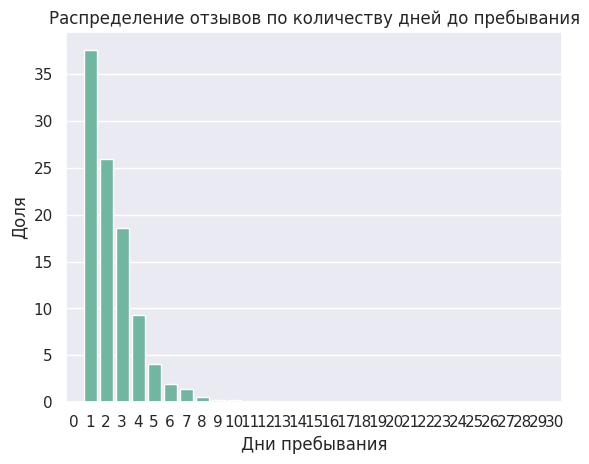

In [32]:
# визуализируем
ax = sns.countplot(hotels_copy, x="number_of_nights", stat='percent',)
ax.set(xlabel='Дни пребывания', ylabel='Доля')
plt.title('Распределение отзывов по количеству дней до пребывания')
plt.show()

**Вывод** подавляющее большинство ревьюэров останавливалось в отелях на период не более 8 дней. На более длительный срок тоже останавливались но таких крайне мало.

In [4]:
hotels_copy = pd.read_csv('data/hotels_eda010.csv')

Тем же способом создадим признаки:`is_leisure_trip`, `is_business_trip`, `is_couple`, `is_solo_traveler`, `is_group`, `is_family_young_child`, `is_family_old_child`, `is_traveler_with_friends`, `is_from_mobile`.

In [7]:
# создаем словарь для генерации новых признаков
ohe_cat_dict ={
    'Leisure trip':'is_leisure_trip',
    'Business trip':'is_business_trip',
    'Couple':'is_couple',
    'Solo traveler':'is_solo_traveler',
    'Group':'is_group',
    'Family with young children':'is_family_young_child',
    'Family with older children':'is_family_old_child',
    'Travelers with friends':'is_traveler_with_friends',
    'Submitted from a mobile device':'is_from_mobile'
    
}

In [8]:
# проходимся циклом по ключам словаря
for key in ohe_cat_dict.keys():
    regex = key 
    # находим только первое значение и приводим к строковому типу данных
    hotels_copy[ohe_cat_dict[key]] = hotels_copy['tags'].str.findall(regex).str.get(0).astype('string')
    # разбиваем строку в список берем второй элемент приводим в числовой формат
    # для данных где такой тег не встречается ставим 0
    hotels_copy[ohe_cat_dict[key]] = hotels_copy[ohe_cat_dict[key]].apply(lambda x: 1 if not pd.isna(x) else 0).astype('int64')
    # отображаем значения
    display(hotels_copy[ohe_cat_dict[key]].value_counts())

is_leisure_trip
1    313593
0     73210
Name: count, dtype: int64

is_business_trip
0    324814
1     61989
Name: count, dtype: int64

is_couple
0    197591
1    189212
Name: count, dtype: int64

is_solo_traveler
0    305568
1     81235
Name: count, dtype: int64

is_group
0    337715
1     49088
Name: count, dtype: int64

is_family_young_child
0    340967
1     45836
Name: count, dtype: int64

is_family_old_child
0    367001
1     19802
Name: count, dtype: int64

is_traveler_with_friends
0    385173
1      1630
Name: count, dtype: int64

is_from_mobile
1    230778
0    156025
Name: count, dtype: int64

In [30]:
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

# Заполнение пропусков

In [31]:
# выбираем сервис геолокации
geolocator = Nominatim(user_agent="SF_agent")

# заполняем пропуски нулями
hotels_copy[['lat','lng']] = hotels_copy[['lat','lng']].fillna(0)
# создаем маску на нули
mask = ((hotels_copy['lat'] == 0) | (hotels_copy['lng'] == 0))
# фильтруем датасет и 
# осталяем только строки с пропусками координат
hotel_none = hotels_copy[mask]

# создаем список названий отлей
hotel_list = hotel_none.hotel_name.value_counts().index.to_list()
# создаем список адресов отелей
hotel_adr = hotel_none.hotel_address.value_counts().index.to_list()

# проходимся циклом по спику кортежей вида [(название отеля, адрес отеля)]
for hotel_name, address in zip(hotel_list, hotel_adr):
    # вычленяем срез c адресом
    address = address.split(' ')[-4:]
    # обратно в строку
    address = address[0]+' '+address[1]+' '+address[2]+' '+address[3]  
    # определяем моесто по адресу
    place = geolocator.geocode(address, exactly_one=True, language='en')
    # заполняем пропуски
    hotels_copy.loc[hotels_copy['hotel_name'].eq(hotel_name) & hotels_copy['lat'].eq(0), 'lat'] = place.latitude
    hotels_copy.loc[hotels_copy['hotel_name'].eq(hotel_name) & hotels_copy['lng'].eq(0), 'lng'] = place.longitude

In [33]:
# Удаляем строковые значения
hotels_copy = hotels_copy.drop(columns=['hotel_address',
                                   'review_date',
                                   'hotel_name',
                                   'reviewer_nationality',
                                   'negative_review',
                                   'positive_review',
                                   'tags'])

In [34]:
# проверяем
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int64  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

In [35]:
# Сохраняем в файл
hotels_copy.to_csv('data/hotels_eda10.csv', index=False)

# Преобразуем признаки с типом данных `object`

In [36]:
# Обработем признак 'is_weekend_review'
hotels_copy['is_weekend_review'] = hotels_copy['is_weekend_review'].apply(lambda x: 1 if x=='weekend' else 0)
hotels_copy['is_weekend_review'].value_counts()

is_weekend_review
0    284844
1    101959
Name: count, dtype: int64

In [37]:
# Обработем признак 'review_season', 'hotel_country', 'positive_review_cat', 'negative_review_cat'
# это категориальные номинальные признаки
# категорий меньше 15 

features = ['review_season', 'hotel_country', 'positive_review_cat', 'negative_review_cat']
# проверим количество категорий
n_cats = []
for feature in features:
    n_cats.append(hotels_copy[feature].value_counts().shape[0])
print(n_cats)

# используем однократное кодирование (OneHot Encoding); 
feature_dummies = pd.get_dummies(hotels_copy, columns=features)


feature_dummies

[4, 6, 6, 6]


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,positive_review_cat_Location,positive_review_cat_Nothing,positive_review_cat_Other,positive_review_cat_Staff,negative_review_cat_Breakfast,negative_review_cat_Location,negative_review_cat_Nothing,negative_review_cat_Other,negative_review_cat_Room,negative_review_cat_Staff
0,581,8.4,3,1994,4,7,10.0,531,51.507894,-0.143671,...,False,False,False,True,False,False,False,True,False,False
1,299,8.3,3,1361,2,14,6.3,203,51.521009,-0.123097,...,True,False,False,False,True,False,False,False,False,False
2,32,8.9,6,406,0,14,7.5,289,48.845377,2.325643,...,False,True,False,False,False,False,False,False,True,False
3,34,7.5,0,607,11,8,10.0,681,48.888697,2.394540,...,True,False,False,False,False,False,True,False,False,False
4,914,8.5,4,7586,20,10,9.6,516,52.385601,4.847060,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,107,9.0,0,617,10,10,8.8,106,51.494028,-0.191050,...,False,False,True,False,False,False,True,False,False,False
386799,272,8.4,0,3224,93,1,9.2,171,48.192379,16.399451,...,False,False,True,False,False,False,True,False,False,False
386800,457,6.8,12,2751,9,21,8.3,543,51.520795,-0.131084,...,True,False,False,False,False,False,False,False,True,False
386801,365,8.1,0,1567,6,28,9.2,74,51.515125,-0.160066,...,True,False,False,False,False,False,True,False,False,False


In [38]:
feature_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int64  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

In [40]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = feature_dummies.drop(['reviewer_score'], axis = 1)  
y = feature_dummies['reviewer_score'] 

In [41]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [42]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [44]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1321146455683315


In [43]:
# разобьем признаки на категориальные и непрерывные

cat_cols = []
num_cols = []
for feature in X.columns:
    if X[feature].value_counts().shape[0]<15:
        # категориальные признаки
        cat_cols.append(feature)
    else:
        # непрерывные признаки
        num_cols.append(feature)
        
print('Непревывные признаки:', num_cols)
print('Категориальные признаки:', cat_cols)
        

Непревывные признаки: ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'number_of_nights']
Категориальные признаки: ['is_weekend_review', 'review_weekday', 'review_month', 'review_equal', 'tags_n', 'review_season_outumn', 'review_season_spring', 'review_season_summer', 'review_season_winter', 'hotel_country_Austria', 'hotel_country_France', 'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain', 'hotel_country_United Kingdom', 'positive_review_cat_Breakfast', 'positive_review_cat_Everithing', 'positive_review_cat_Location', 'positive_review_cat_Nothing', 'positive_review_cat_Other', 'positive_review_cat_Staff', 'negative_review_cat_Breakfast', 'negative_review_cat_Location', 'negative_review_cat_Nothing', 'negative_review_cat_Other', 'negative_review_cat_Room', 'negative_review_cat_Staff

Проанализируем значимость

<Axes: >

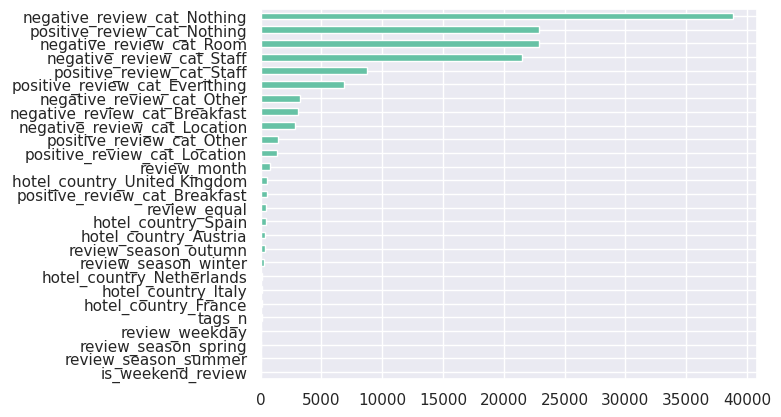

In [45]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [46]:
# выберем 10 значимых категориальных признаков
cat_cols_high = imp_cat.sort_values(ascending=False).nlargest(10).index.to_list()
cat_cols_high

['negative_review_cat_Nothing',
 'positive_review_cat_Nothing',
 'negative_review_cat_Room',
 'negative_review_cat_Staff',
 'positive_review_cat_Staff',
 'positive_review_cat_Everithing',
 'negative_review_cat_Other',
 'negative_review_cat_Breakfast',
 'negative_review_cat_Location',
 'positive_review_cat_Other']

<Axes: >

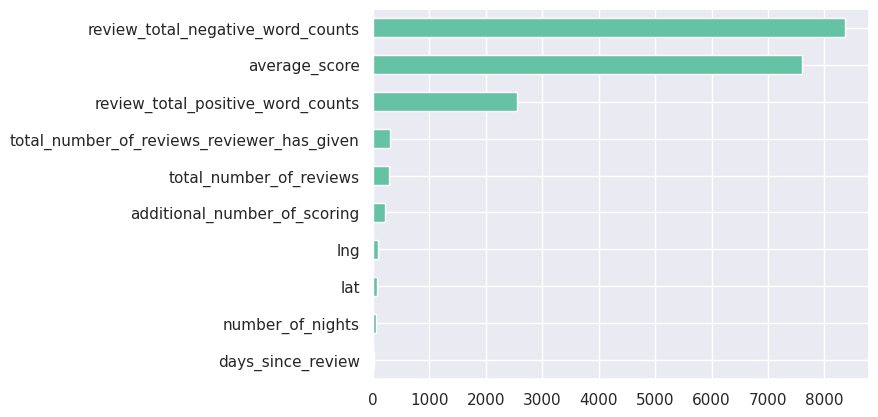

In [47]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [48]:
imp_num.sort_values(ascending=False)

review_total_negative_word_counts             8370.030082
average_score                                 7599.158955
review_total_positive_word_counts             2554.120021
total_number_of_reviews_reviewer_has_given     300.284423
total_number_of_reviews                        278.207325
additional_number_of_scoring                   211.415581
lng                                             92.478743
lat                                             75.413932
number_of_nights                                47.375977
days_since_review                               26.918686
dtype: float64

In [49]:
# выберем 3 значимых непрерывных признаков
num_cols_high = imp_num.sort_values(ascending=False).nlargest(3).index.to_list()
num_cols_high

['review_total_negative_word_counts',
 'average_score',
 'review_total_positive_word_counts']

In [50]:
# объединим списки высокозначимых признаков
high_cols = num_cols_high + cat_cols_high

In [51]:
# Разделим данные
X = feature_dummies.drop(['reviewer_score'], axis = 1)  
y = feature_dummies['reviewer_score'] 

# оставим только высокозначимые признаки
for col in X.columns:
    if col not in high_cols:
        X =X.drop([col], axis=1)

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)) 


MAPE: 0.1392707666034214


In [39]:
cols_to_normalize = ['additional_number_of_scoring', 'review_total_negative_word_counts','total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'tags_n', 'number_of_nights']

# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler(feature_range=(0, 10))

# кодируем исходный датасет
df_mm = mm_scaler.fit_transform(feature_dummies[cols_to_normalize])

# Преобразуем промежуточный датасет 
df_mm = pd.DataFrame(df_mm, columns=cols_to_normalize)
# Удаляем из исходного датасета исходные колонки
feature_dummies_mod = feature_dummies.drop(cols_to_normalize, axis=1)
# добавляем результат к исходному DataFrame
feature_dummies_mod = pd.concat([feature_dummies_mod, df_mm], axis=1)

feature_dummies_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   reviewer_score                              386803 non-null  float64
 2   days_since_review                           386803 non-null  int64  
 3   lat                                         386803 non-null  float64
 4   lng                                         386803 non-null  float64
 5   is_weekend_review                           386803 non-null  int64  
 6   review_weekday                              386803 non-null  int32  
 7   review_month                                386803 non-null  int32  
 8   review_equal                                386803 non-null  int64  
 9   is_leisure_trip                             386803 non-null  int64  
 

In [40]:
# Делим датасет на
# часть для обучения модели
X = feature_dummies_mod.drop(['reviewer_score'], axis = 1)  
# целевой признак
y = feature_dummies_mod['reviewer_score'] 

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13155311038200335
